## Lab 1: 
### Information about data:
Original data set can be found here: https://www.kaggle.com/rtatman/chocolate-bar-ratings

Data contains 9 columns: *Company* (Name of the company manufacturing the bar), *Specific Bean Origin or Bar Name* (The specific geo-region of origin for the bar), *REF* (A value linked to when the review was entered in the database. Higher = more recent), *Review Date* (Date of publication of the review), *Cocoa Percent* (Cocoa percentage (darkness) of the chocolate bar being reviewed), *Company Location* (Manufacturer base country), *Rating* (Expert rating for the bar), *Bean Type* (The variety (breed) of bean used, if provided), *Broad Bean Origin* (The broad geo-region of origin for the bean).

### Steps:
0. Describe the problem
1. Read the data
2. Visualize the data and calculate the main characteristics (average, scatter, correlation matrix, etc.). Interpret it.
3. Process the missing values (or make sure that they are not)
4. Process categorical features
5. Normalize (or explain why in your case it is not needed)
6. Split the data into training and test samples
7. Run the nearest neighbors classifier (try a different number of them)
8. Calculate errors in the training and test samples. To conclude
9. Optionally: launch other classifiers. Compare Results
10. Optionally: somehow fight against the imbalance of classes (if any)
11. Optionally: exclude correlated variables (explain why)
12. Draw general conclusions

## Step 0: Describe the problem

Need to classify the quality of cocoa. To rate used range from 1 to 5 with 0.25 step

## Step 1: Read the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
data = pd.read_csv("./flavors_of_cacao.csv")
data.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


### Additional step: update the data before visualizing

In [3]:
# Rename columns 
original_colnames = data.columns
new_colnames = ['company', 'species', 'REF', 'review_year', 'cocoa_p',
                'company_location', 'rating', 'bean_typ', 'country']
data = data.rename(columns=dict(zip(original_colnames, new_colnames)))

In [4]:
# "REF" and "review_year" approximately means the same, so remove "REF column from the data
data = data.drop("REF", axis=1)
# There is no meaningful idea how to use 'review_year' for classification, so also remove it
data = data.drop("review_year", axis=1)

In [5]:
# Modify data types
data['cocoa_p'] = data['cocoa_p'].str.replace('%', '').astype(float)/100

In [6]:
# Update namings of countries
def update_namings(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        if isinstance(text, str):
            text = re.sub(i, j, text)
    return text

data['country'] = data['country'].str.replace('.', '').apply(update_namings)
data['bean_typ'] = data['bean_typ'].str.replace('.', '').apply(update_namings)

## Update misspellings in data['company_location']
data['company_location'] = data['company_location']\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

### Step 2: Visualize the data and collect metrics

In [7]:
data.describe(include="all")

,company,species,cocoa_p,company_location,rating,bean_typ,country
count,1795,1795,1795.000000,1795,1795.000000,1794,1794
unique,416,1039,NaN,59,NaN,41,97
top,Soma,Madagascar,NaN,U.S.A.,NaN,,Venezuela
freq,47,57,NaN,764,NaN,887,214
mean,NaN,NaN,0.716983,NaN,3.185933,NaN,NaN
std,NaN,NaN,0.063231,NaN,0.478062,NaN,NaN
min,NaN,NaN,0.420000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,0.700000,NaN,2.875000,NaN,NaN
50%,NaN,NaN,0.700000,NaN,3.250000,NaN,NaN
75%,NaN,NaN,0.750000,NaN,3.500000,NaN,NaN


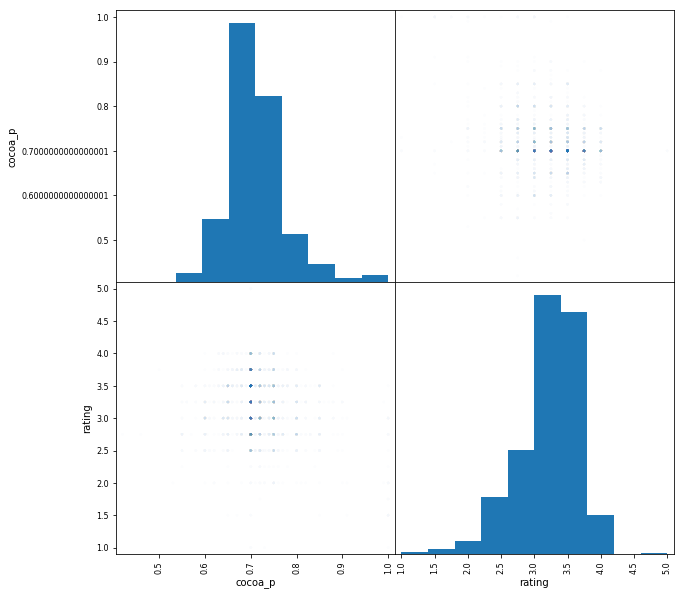

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

According to the table, there is a huge distribution between rating and cocoa percentage. 

In [9]:
data.corr()

,cocoa_p,rating
cocoa_p,1.00000,-0.16482
rating,-0.16482,1.00000


Correlation table confirms the absence of dependencies between it.

#### Create histograms of feature distributions

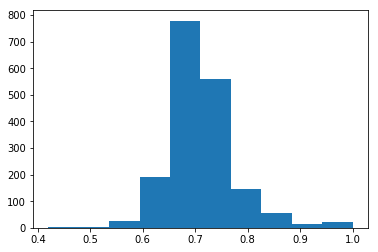

In [10]:
# Visualize distribution of Cocoa Percent
plt.hist(data["cocoa_p"])
pass

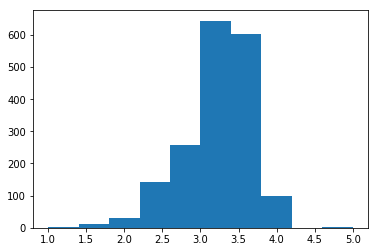

In [11]:
# Visualize distribution of Rating
plt.hist(data["rating"])
pass

### Step 3: Process of missed values

1. Check null values in every column:

In [12]:
for column in data.columns:
    print("Column '{}', number of null values: \n{}\n".format(column, data[column].isnull().value_counts()))

Column 'company', number of null values: 
False    1795
Name: company, dtype: int64

Column 'species', number of null values: 
False    1795
Name: species, dtype: int64

Column 'cocoa_p', number of null values: 
False    1795
Name: cocoa_p, dtype: int64

Column 'company_location', number of null values: 
False    1795
Name: company_location, dtype: int64

Column 'rating', number of null values: 
False    1795
Name: rating, dtype: int64

Column 'bean_typ', number of null values: 
False    1794
True        1
Name: bean_typ, dtype: int64

Column 'country', number of null values: 
False    1794
True        1
Name: country, dtype: int64



In [13]:
# Because data['country'] contains null values, replace it from data['species']
data['country'] = data['country'].fillna(data['species'])

In [14]:
# Because data['bean_typ'] contains null values, remove corresponding rows
data = data.dropna(subset=["bean_typ"], axis=0)

2. Check empty (' ') values in every column:

In [15]:
for column in data.columns:
    try:
        print("Column '{}', number of empty values: \n{}\n".format(column, len(data[data[column].str.len()==1])))
    except:
        continue

Column 'company', number of empty values: 
0

Column 'species', number of empty values: 
0

Column 'company_location', number of empty values: 
0

Column 'bean_typ', number of empty values: 
887

Column 'country', number of empty values: 
73



In [16]:
# For data["country"] empty value means Blend type of beans
data["country"] = data["country"].str.replace(" ", "Blend")
len(data[data["country"].str.len()==1]["country"])

0

In [17]:
# For data["bean_typ"] empty values will be replaced the next way: common for the company if it can be found or common for all the data
top_argmax = data["bean_typ"].describe().top
for company in data["company"].unique():
    subdata = data[(data["company"] == company) & (data["bean_typ"].str.len()!=1)]
    try:
        argmax = subdata["bean_typ"].value_counts().idxmax()
    except:
        argmax = top_argmax
    data.loc[(data["company"] == company) & (data["bean_typ"].str.len()==1), "bean_typ"] = argmax
len(data[data["bean_typ"].str.len()==1]["bean_typ"])

267

### Step 4: Process categorial features

In [18]:
categorical_cols = [x for x in data.columns if data[x].dtype=='object']
data[categorical_cols].describe()

,company,species,company_location,bean_typ,country
count,1794,1794,1794,1794,1794
unique,416,1038,59,41,96
top,Soma,Madagascar,U.S.A.,Trinitario,Venezuela
freq,46,57,764,763,214


According to the table above, there are a lot of categorical features, so we can use feature engineering to replace categorical features with numeric features. We will add "is_blend" feature (1 means that the cocoa isn't pure and 0 otherwise) and "is_domestic" (1 when company location and country are the same and 0 otherwise) - it will will allow us to get rid of few categorical columns.

In [19]:
data['is_blend'] = np.where(
    np.logical_or(
        np.logical_or(data['species'].str.lower().str.contains(',|(blend)|;'),
                      data['country'] == "Blend"),
        data['country'].str.lower().str.contains(',')
    )
    , 1
    , 0
)

data['is_blend'].value_counts()

c:\users\vurusovs\desktop\my_work\hse_iad\ml_n_data_analysis\.env3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


0    1096
1     698
Name: is_blend, dtype: int64

In [20]:
data['is_domestic'] = np.where(data['country'] == data['company_location'], 1, 0)
data['is_domestic'].value_counts()

0    1604
1     190
Name: is_domestic, dtype: int64

In [21]:
data_to_solve = data.drop(["species", "company_location", "country"], axis=1)
categorical_cols = [x for x in data_to_solve.columns if data_to_solve[x].dtype=='object']
data_to_solve[categorical_cols].describe()

,company,bean_typ
count,1794,1794
unique,416,41
top,Soma,Trinitario
freq,46,763


Need to convert remaining categorical features to numeric features. To do it we will use hashing.

In [22]:
for col_name in ["company", "bean_typ"]:
    for val in data_to_solve[col_name].unique():
        data_to_solve.loc[data_to_solve[col_name] == val, col_name] = hash(col_name+"_"+val) % 500

In [23]:
(data_to_solve["company"] == data_to_solve["bean_typ"]).all()

False

All categorical features were converted to unique numeric features.

### Step 5: Normalization

In [24]:
from sklearn.preprocessing import scale

X = data_to_solve.drop('rating', axis = 1)
feature_names = X.columns
X = scale(X)
# Convert rating to integer value
y = data_to_solve['rating'] * 100

### Step 6: Split the data to train and test parts

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

1435 359


### Step 7: Try kNN

#### 1. Try n_neighbors = 3

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [27]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)
err_test_n3  = np.mean(y_test  != y_test_predict)
err_train_n3  = np.mean(y_train  != y_train_predict)

#### 2. Try n_neighbors = 7

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [29]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)
err_test_n7  = np.mean(y_test  != y_test_predict)
err_train_n7  = np.mean(y_train  != y_train_predict)

#### 3. Try n_neighbors = 15

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [31]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)
err_test_n15  = np.mean(y_test  != y_test_predict)
err_train_n15  = np.mean(y_train  != y_train_predict)

### Step 8: Collect errors

In [32]:
print(err_train_n3, err_test_n3)

0.5247386759581881 0.8161559888579387


In [33]:
print(err_train_n7, err_test_n7)

0.6020905923344948 0.807799442896936


In [34]:
print(err_train_n15, err_test_n15)

0.6773519163763067 0.7799442896935933


The best results on test data found with n_neighbors = 7, but the errors on test and train data are still huge. There can be the next reasons:
1. Few categorical features were hashed;
2. Wrong feature engineering;
3. Wrong filling out of missed data.

Need to check another classifiers.

### Step 9: Try other classifiers

#### 1. SVM

In [35]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.7289198606271777 0.7604456824512534


#### 2. Random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.2048780487804878 0.7910863509749304


#### 3. AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators = 1000)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test = np.mean(y_test != ada.predict(X_test))

print(err_train, err_test)

0.8020905923344948 0.8161559888579387


#### 4. Gradient boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier(n_estimators = 1000)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print(err_train, err_test)

0.22090592334494774 0.8245125348189415


The best results were found with SVM, but all classifiers demonstrate approximately the same error on test data. Note: random forest shows retraining (in comparison with other classifiers) on train data.

### Step 12: General conclusion

All classifiers shows huge error on provided data. The main reason is a problem with data. There can be different causes: 
1. Raw data contains a lot of errors;
2. Mistaken preprocessing (filling out of missed data, feature engineering etc.);
3. Small number of data to train.